In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import pad
import torchaudio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import math
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import torchaudio.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader, Dataset
import seaborn as sns

# Data Prepration

In [2]:
data = pd.read_csv('birdclef-2024/eBird_Taxonomy_v2021.csv')
data

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN
...,...,...,...,...,...,...,...,...,...
16748,34694,species,slcgro1,Slate-colored Grosbeak,Saltator grossus,Passeriformes,Thraupidae (Tanagers and Allies),NaN,NaN
16749,34697,species,bltgro2,Black-throated Grosbeak,Saltator fuliginosus,Passeriformes,Thraupidae (Tanagers and Allies),NaN,NaN
16750,34698,spuh,saltat1,saltator sp.,Saltator sp.,Passeriformes,Thraupidae (Tanagers and Allies),NaN,NaN
16751,34699,spuh,passer1,passerine sp.,Passeriformes sp.,Passeriformes,NaN,Others,NaN


In [3]:
train_path = 'birdclef-2024/train_audio/'
train_data = []
for folder in os.listdir(train_path):
    for file in os.listdir(train_path + folder):
        train_data.append((train_path + folder + '/' + file, folder))

In [4]:
max_length = 480000

In [5]:
X = np.array(train_data)[:, 0]
y = np.array(train_data)[:, 1]
y = y.reshape(-1, 1)

In [6]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_transformed = enc.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

In [8]:
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, max_length, transform):
        self.file_paths = file_paths
        self.labels = labels
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        audio, _ = torchaudio.load(file_path)
        if audio.shape[1] < self.max_length:
            padding = self.max_length - audio.shape[1]
            audio = F.pad(audio, (0, padding))
        else:
            audio = audio[:, :self.max_length]
        audio = self.transform(audio)
        audio = (audio - audio.mean()) / audio.std()
        return audio, label

In [9]:
sr = 32000
transform = T.MelSpectrogram(sr, n_fft=2028, n_mels=128, hop_length=480000 // (384 - 1),
                             window_fn=torch.hann_window, f_max=16000, f_min=20)

# Training loop

In [10]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs, device):
    history = []
    validation_loss = []
    training_loss = []
    best_val_accuracy = 0.0

    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            history.append(loss.item())

        avg_train_loss = running_loss / len(train_loader)
        scheduler.step()
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}')
        training_loss.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == torch.max(labels, 1)[1]).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        validation_loss.append(avg_val_loss)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return history, training_loss, validation_loss, best_val_accuracy

In [11]:
def plot_losses(epochs, training_loss, validation_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), training_loss, label='Training Loss')
    plt.plot(range(1, epochs+1), validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [31]:
batch_size = 32
train_loader = DataLoader(
    dataset=AudioDataset(X_train, y_train, max_length, transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)
val_loader = DataLoader(
    dataset=AudioDataset(X_test, y_test, max_length, transform),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)

# Evaluation

In [13]:
def evaluate_model(model, test_loader, device):
    model.eval()  
    
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

# Baseline model

In [14]:
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        
        self.conv0 = nn.Conv2d(1, 8, kernel_size=2, padding=1)
        self.conv1 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.bn0 = nn.BatchNorm2d(8)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.dropout_conv = nn.Dropout(0.3)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.pool(self.relu(self.bn0(self.conv0(x))))
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

num_classes = 182
batch_size = 64
epochs = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AudioCNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [15]:
history, train_loss, val_loss, base_line_acc = train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs, device)

  0%|                                                     | 0/6 [00:00<?, ?it/s]/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/6, Train Loss: 3.8749


 17%|███████▎                                    | 1/6 [07:05<35:28, 425.76s/it]

Epoch [1/6], Train Loss: 3.8749, Val Loss: 3.3701, Val Accuracy: 20.61%
Epoch 2/6, Train Loss: 3.0347


 33%|██████████████▋                             | 2/6 [14:10<28:20, 425.11s/it]

Epoch [2/6], Train Loss: 3.0347, Val Loss: 3.1380, Val Accuracy: 26.72%
Epoch 3/6, Train Loss: 2.5089


 50%|██████████████████████                      | 3/6 [21:14<21:14, 424.84s/it]

Epoch [3/6], Train Loss: 2.5089, Val Loss: 2.5649, Val Accuracy: 38.51%
Epoch 4/6, Train Loss: 2.3783


 67%|█████████████████████████████▎              | 4/6 [28:19<14:09, 424.76s/it]

Epoch [4/6], Train Loss: 2.3783, Val Loss: 2.4867, Val Accuracy: 40.17%
Epoch 5/6, Train Loss: 2.2956


 83%|████████████████████████████████████▋       | 5/6 [35:21<07:03, 423.84s/it]

Epoch [5/6], Train Loss: 2.2956, Val Loss: 2.4568, Val Accuracy: 40.76%
Epoch 6/6, Train Loss: 2.2804


100%|████████████████████████████████████████████| 6/6 [42:30<00:00, 425.12s/it]

Epoch [6/6], Train Loss: 2.2804, Val Loss: 2.4500, Val Accuracy: 41.29%


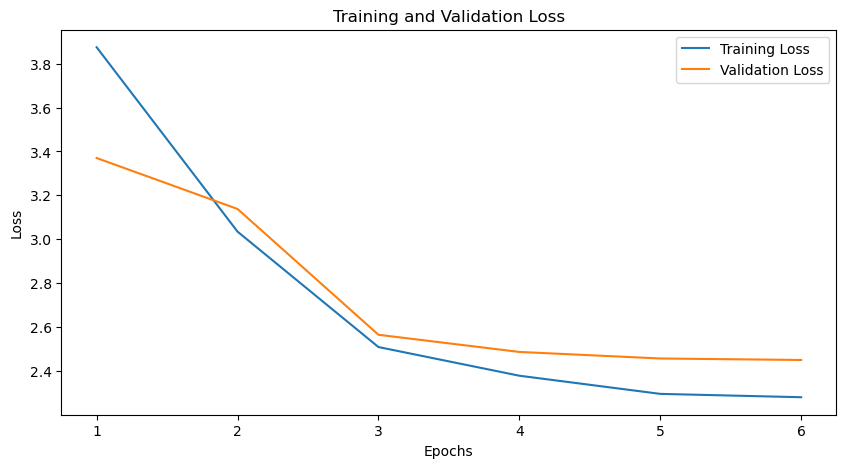

In [16]:
plot_losses(epochs, train_loss, val_loss)

100%|███████████████████████████████████████████| 77/77 [01:25<00:00,  1.11s/it]


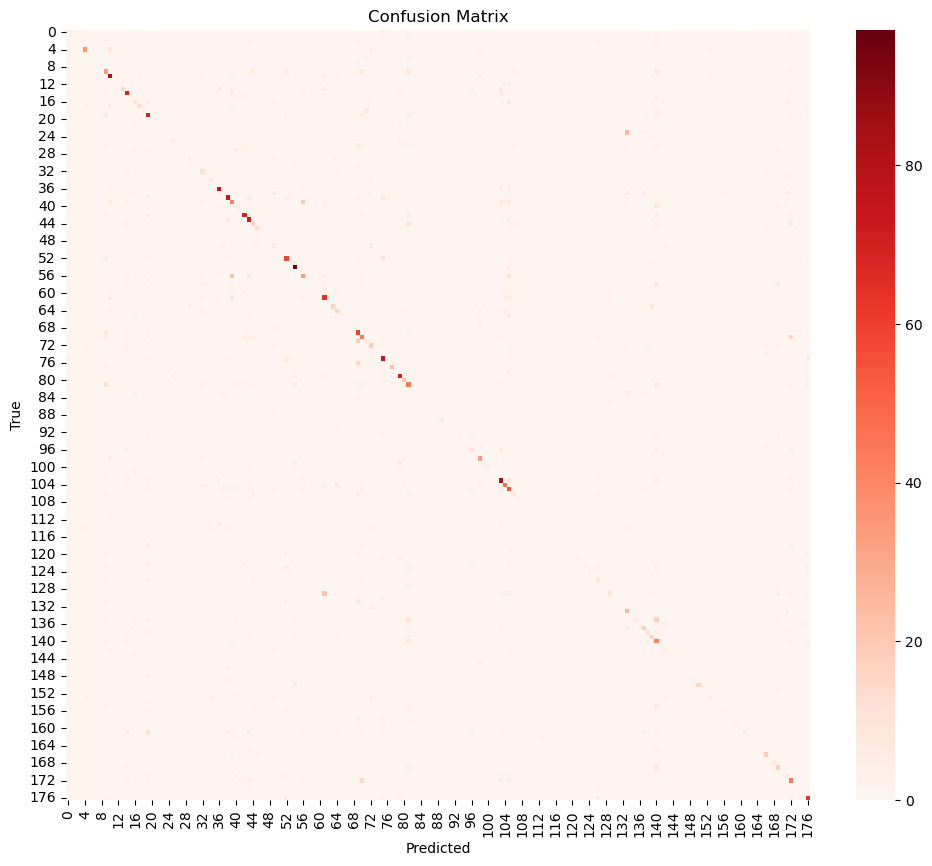

In [17]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
evaluate_model(model, val_loader, device)

100%|███████████████████████████████████████████| 77/77 [01:24<00:00,  1.10s/it]

Accuracy: 0.4129
Precision: 0.3811
Recall: 0.4129
F1 Score: 0.3718



/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# AlexNet

In [19]:
model = torchvision.models.alexnet(pretrained=True)

model.features[0] = nn.Conv2d(1, model.features[0].out_channels,
                              kernel_size=model.features[0].kernel_size,
                              stride=model.features[0].stride,
                              padding=model.features[0].padding,
                              bias=False)


model.classifier[6] = nn.Linear(model.classifier[6].in_features, 182)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, 

In [20]:
num_classes = 182
epochs = 6
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
history, train_loss, val_loss, alex_acc = train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs, device)

  0%|                                                     | 0/6 [00:00<?, ?it/s]/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/6, Train Loss: 4.0580


 17%|███████▎                                    | 1/6 [07:04<35:24, 424.93s/it]

Epoch [1/6], Train Loss: 4.0580, Val Loss: 3.6145, Val Accuracy: 17.19%
Epoch 2/6, Train Loss: 3.5281


 33%|██████████████▋                             | 2/6 [14:08<28:17, 424.32s/it]

Epoch [2/6], Train Loss: 3.5281, Val Loss: 3.3010, Val Accuracy: 22.40%
Epoch 3/6, Train Loss: 3.0593


 50%|██████████████████████                      | 3/6 [21:12<21:12, 424.14s/it]

Epoch [3/6], Train Loss: 3.0593, Val Loss: 2.9760, Val Accuracy: 29.58%
Epoch 4/6, Train Loss: 2.8869


 67%|█████████████████████████████▎              | 4/6 [28:16<14:08, 424.10s/it]

Epoch [4/6], Train Loss: 2.8869, Val Loss: 2.9008, Val Accuracy: 31.70%
Epoch 5/6, Train Loss: 2.7683


 83%|████████████████████████████████████▋       | 5/6 [35:20<07:04, 424.07s/it]

Epoch [5/6], Train Loss: 2.7683, Val Loss: 2.8697, Val Accuracy: 32.46%
Epoch 6/6, Train Loss: 2.7410


100%|████████████████████████████████████████████| 6/6 [42:31<00:00, 425.20s/it]

Epoch [6/6], Train Loss: 2.7410, Val Loss: 2.8600, Val Accuracy: 32.36%


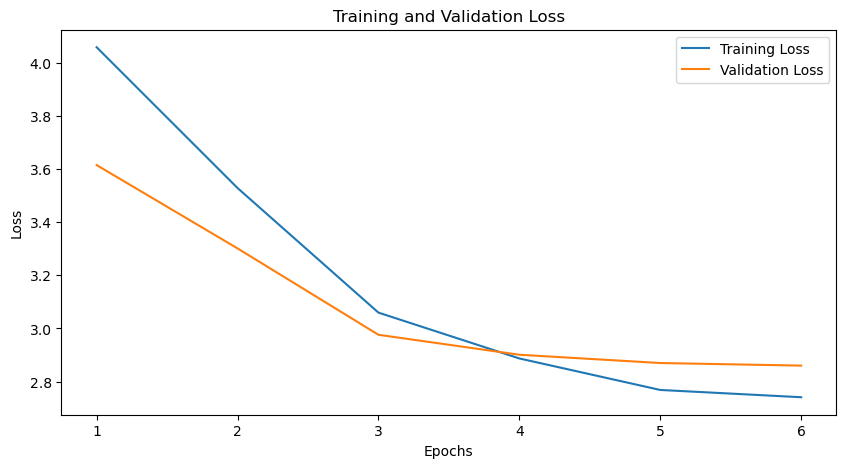

In [21]:
plot_losses(epochs, train_loss, val_loss)

100%|███████████████████████████████████████████| 77/77 [01:25<00:00,  1.11s/it]


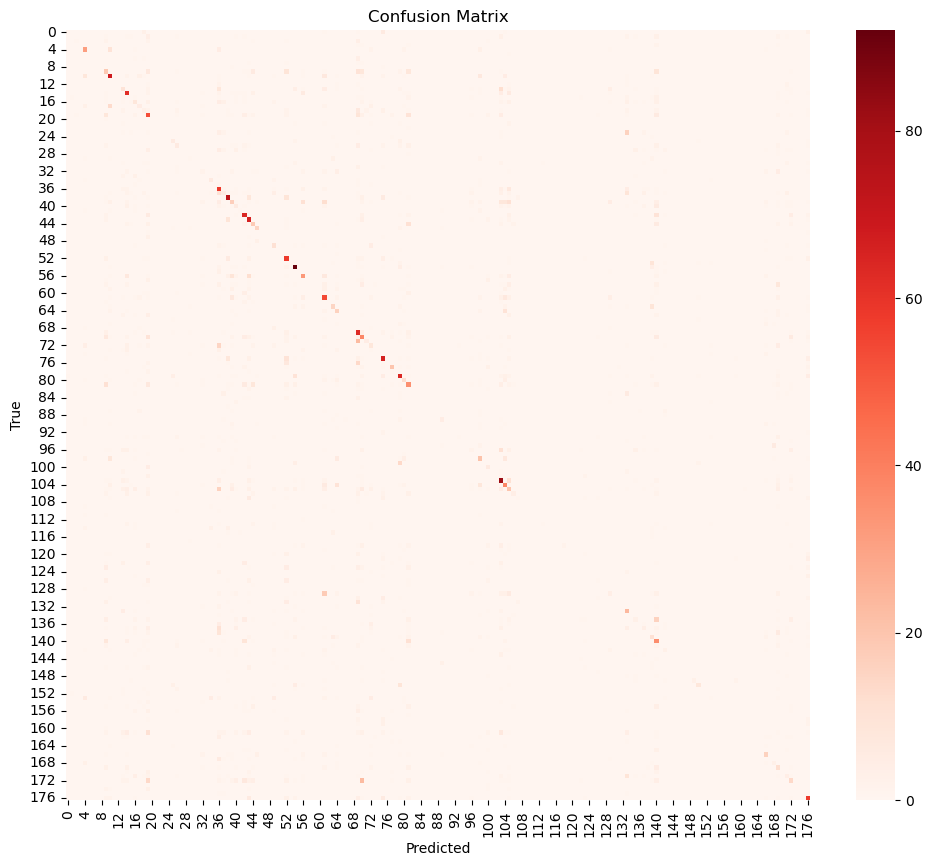

In [22]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
evaluate_model(model, val_loader, device)

100%|███████████████████████████████████████████| 77/77 [01:24<00:00,  1.10s/it]

Accuracy: 0.3236
Precision: 0.2641
Recall: 0.3236
F1 Score: 0.2749



/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ResNet50

In [24]:
model = torchvision.models.resnet50(pretrained=True)

model.conv1 = nn.Conv2d(1, model.conv1.out_channels, 
                        kernel_size=model.conv1.kernel_size, 
                        stride=model.conv1.stride, 
                        padding=model.conv1.padding, 
                        bias=False)

model.fc = nn.Linear(model.fc.in_features, 182)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
num_classes = 182
epochs = 6
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
history, train_loss, val_loss, resnet50_acc = train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs, device)

  0%|                                                     | 0/6 [00:00<?, ?it/s]

Epoch 1/6, Train Loss: 3.9626


 17%|███████▎                                    | 1/6 [08:35<42:55, 515.10s/it]

Epoch [1/6], Train Loss: 3.9626, Val Loss: 3.5049, Val Accuracy: 22.59%
Epoch 2/6, Train Loss: 2.7206


 33%|██████████████▋                             | 2/6 [17:14<34:30, 517.65s/it]

Epoch [2/6], Train Loss: 2.7206, Val Loss: 2.5284, Val Accuracy: 40.99%
Epoch 3/6, Train Loss: 1.9834


 50%|██████████████████████                      | 3/6 [25:58<26:01, 520.50s/it]

Epoch [3/6], Train Loss: 1.9834, Val Loss: 2.0042, Val Accuracy: 51.31%
Epoch 4/6, Train Loss: 1.7759


 67%|█████████████████████████████▎              | 4/6 [34:41<17:23, 521.63s/it]

Epoch [4/6], Train Loss: 1.7759, Val Loss: 1.9204, Val Accuracy: 53.68%
Epoch 5/6, Train Loss: 1.5810


 83%|████████████████████████████████████▋       | 5/6 [43:24<08:41, 521.90s/it]

Epoch [5/6], Train Loss: 1.5810, Val Loss: 1.8367, Val Accuracy: 56.21%
Epoch 6/6, Train Loss: 1.5381


100%|████████████████████████████████████████████| 6/6 [52:03<00:00, 520.63s/it]

Epoch [6/6], Train Loss: 1.5381, Val Loss: 1.8179, Val Accuracy: 56.56%


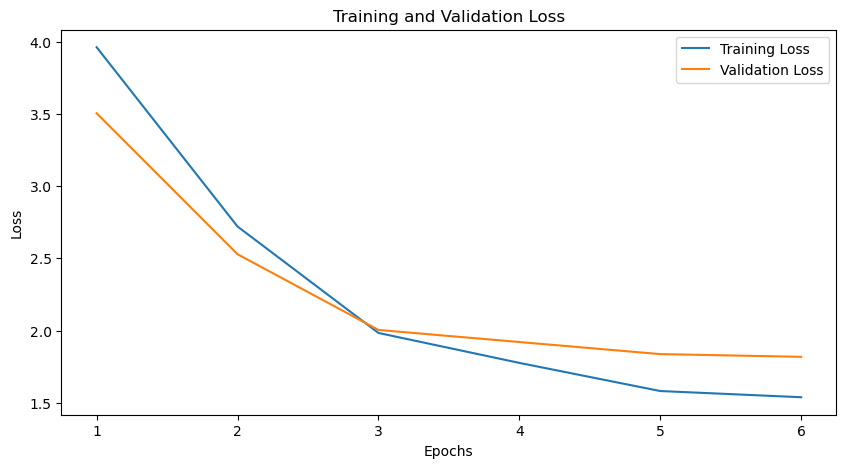

In [26]:
plot_losses(epochs, train_loss, val_loss)

100%|███████████████████████████████████████████| 77/77 [01:32<00:00,  1.20s/it]


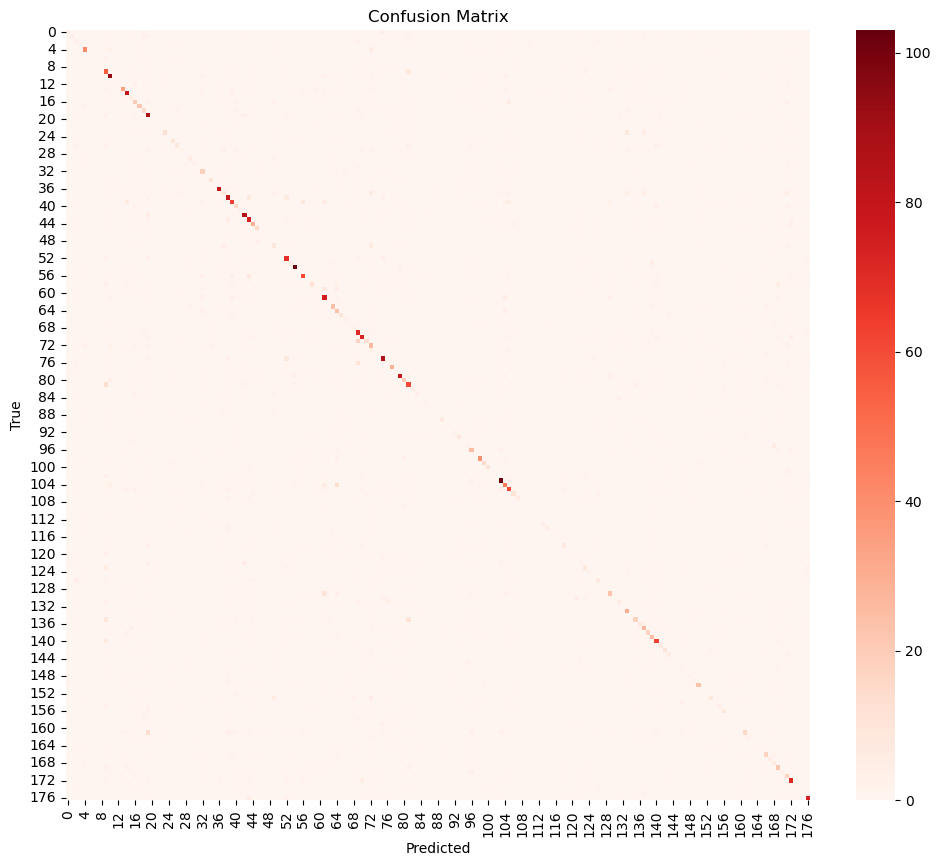

In [27]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
evaluate_model(model, val_loader, device)

100%|███████████████████████████████████████████| 77/77 [01:33<00:00,  1.21s/it]

Accuracy: 0.5656
Precision: 0.5488
Recall: 0.5656
F1 Score: 0.5430



/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ResNet152

In [32]:
model = torchvision.models.resnet152(pretrained=True)

model.conv1 = nn.Conv2d(1, model.conv1.out_channels, 
                        kernel_size=model.conv1.kernel_size, 
                        stride=model.conv1.stride, 
                        padding=model.conv1.padding, 
                        bias=False)

model.fc = nn.Linear(model.fc.in_features, 182)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
num_classes = 182
epochs = 6
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
history, train_loss, val_loss, resnet152_acc = train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs, device)

  0%|                                                     | 0/6 [00:00<?, ?it/s]/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/6, Train Loss: 4.0074


 17%|███████▎                                    | 1/6 [11:16<56:20, 676.18s/it]

Epoch [1/6], Train Loss: 4.0074, Val Loss: 3.3940, Val Accuracy: 23.75%
Epoch 2/6, Train Loss: 2.8528


 33%|██████████████▋                             | 2/6 [22:40<45:22, 680.68s/it]

Epoch [2/6], Train Loss: 2.8528, Val Loss: 2.5111, Val Accuracy: 41.86%
Epoch 3/6, Train Loss: 2.1809


 50%|██████████████████████                      | 3/6 [34:09<34:13, 684.51s/it]

Epoch [3/6], Train Loss: 2.1809, Val Loss: 2.1464, Val Accuracy: 49.16%
Epoch 4/6, Train Loss: 1.9778


 67%|█████████████████████████████▎              | 4/6 [45:33<22:48, 684.33s/it]

Epoch [4/6], Train Loss: 1.9778, Val Loss: 2.0349, Val Accuracy: 51.74%
Epoch 5/6, Train Loss: 1.8326


 83%|████████████████████████████████████▋       | 5/6 [56:52<11:22, 682.43s/it]

Epoch [5/6], Train Loss: 1.8326, Val Loss: 1.9898, Val Accuracy: 52.90%
Epoch 6/6, Train Loss: 1.7892


100%|██████████████████████████████████████████| 6/6 [1:08:13<00:00, 682.27s/it]

Epoch [6/6], Train Loss: 1.7892, Val Loss: 1.9673, Val Accuracy: 53.82%


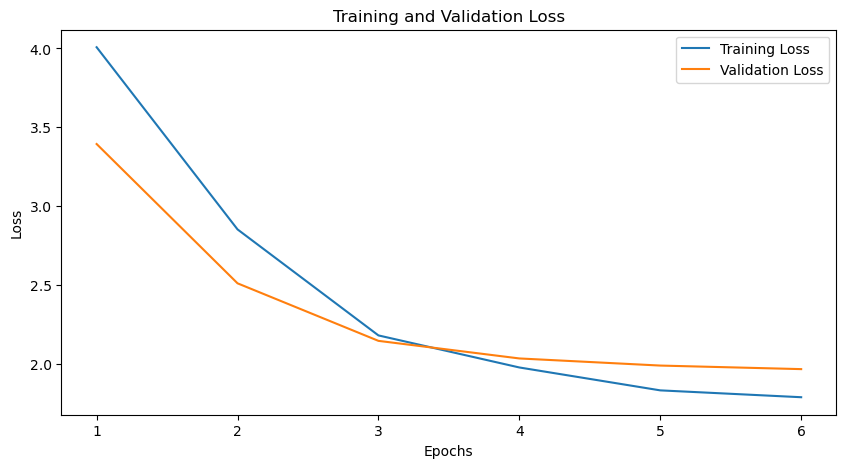

In [34]:
plot_losses(epochs, train_loss, val_loss)

100%|█████████████████████████████████████████| 153/153 [01:44<00:00,  1.46it/s]


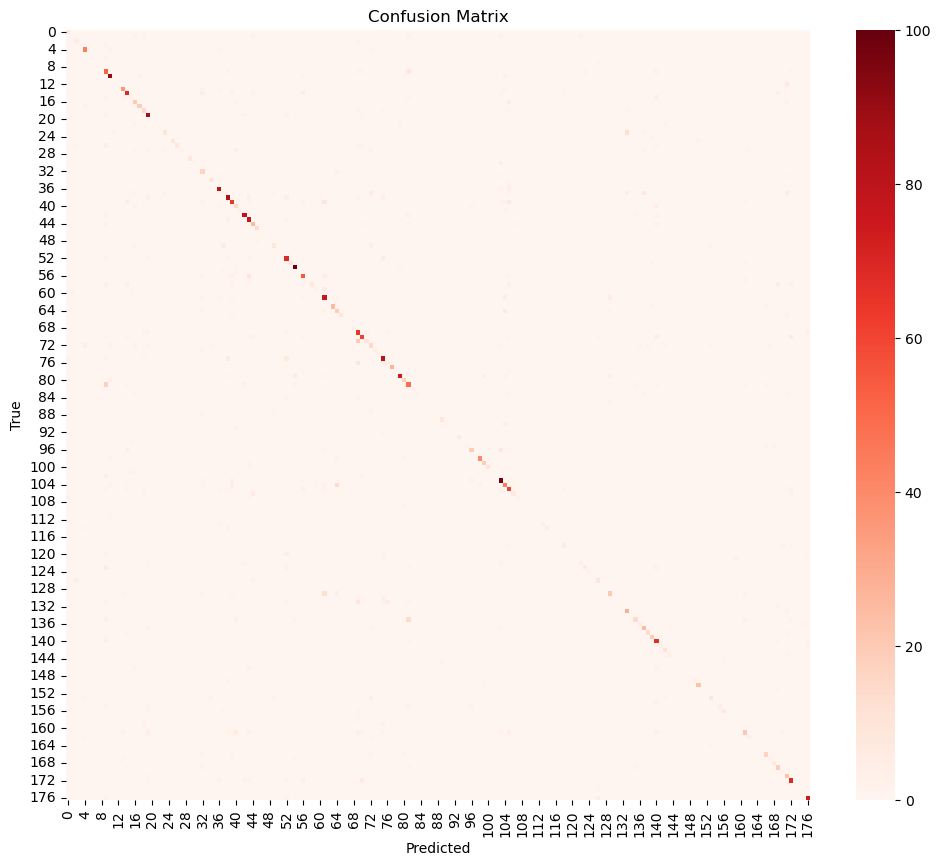

In [35]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [36]:
evaluate_model(model, val_loader, device)

100%|█████████████████████████████████████████| 153/153 [01:45<00:00,  1.45it/s]

Accuracy: 0.5382
Precision: 0.5167
Recall: 0.5382
F1 Score: 0.5109



/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# EfficientNet_v2_s

In [13]:
model = torchvision.models.efficientnet_v2_s(pretrained=True)
model.features[0][0] = nn.Conv2d(1, model.features[0][0].out_channels, 
                                 kernel_size=model.features[0][0].kernel_size, 
                                 stride=model.features[0][0].stride, 
                                 padding=model.features[0][0].padding,
                                 bias=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 182)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [14]:
num_classes = 182
epochs = 6
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
history, train_loss, val_loss, efficientnet_acc = train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs, device)

  0%|                                                     | 0/6 [00:00<?, ?it/s]

Epoch 1/6, Train Loss: 3.0276


 17%|███████▎                                    | 1/6 [08:58<44:50, 538.16s/it]

Epoch [1/6], Train Loss: 3.0276, Val Loss: 2.3527, Val Accuracy: 43.70%
Epoch 2/6, Train Loss: 1.9162


 33%|██████████████▋                             | 2/6 [17:57<35:56, 539.04s/it]

Epoch [2/6], Train Loss: 1.9162, Val Loss: 1.9151, Val Accuracy: 54.87%
Epoch 3/6, Train Loss: 1.1838


 50%|██████████████████████                      | 3/6 [27:03<27:05, 541.87s/it]

Epoch [3/6], Train Loss: 1.1838, Val Loss: 1.2991, Val Accuracy: 68.95%
Epoch 4/6, Train Loss: 0.9619


 67%|█████████████████████████████▎              | 4/6 [36:10<18:07, 543.88s/it]

Epoch [4/6], Train Loss: 0.9619, Val Loss: 1.2474, Val Accuracy: 70.50%
Epoch 5/6, Train Loss: 0.7973


 83%|████████████████████████████████████▋       | 5/6 [45:16<09:04, 544.67s/it]

Epoch [5/6], Train Loss: 0.7973, Val Loss: 1.2264, Val Accuracy: 71.05%
Epoch 6/6, Train Loss: 0.7694


100%|████████████████████████████████████████████| 6/6 [54:24<00:00, 544.07s/it]

Epoch [6/6], Train Loss: 0.7694, Val Loss: 1.2171, Val Accuracy: 71.20%


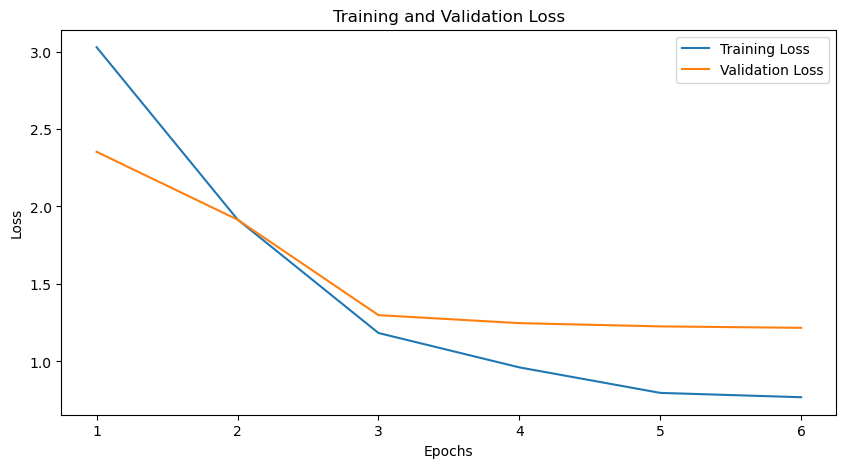

In [15]:
plot_losses(epochs, train_loss, val_loss)

100%|███████████████████████████████████████████| 77/77 [01:34<00:00,  1.22s/it]


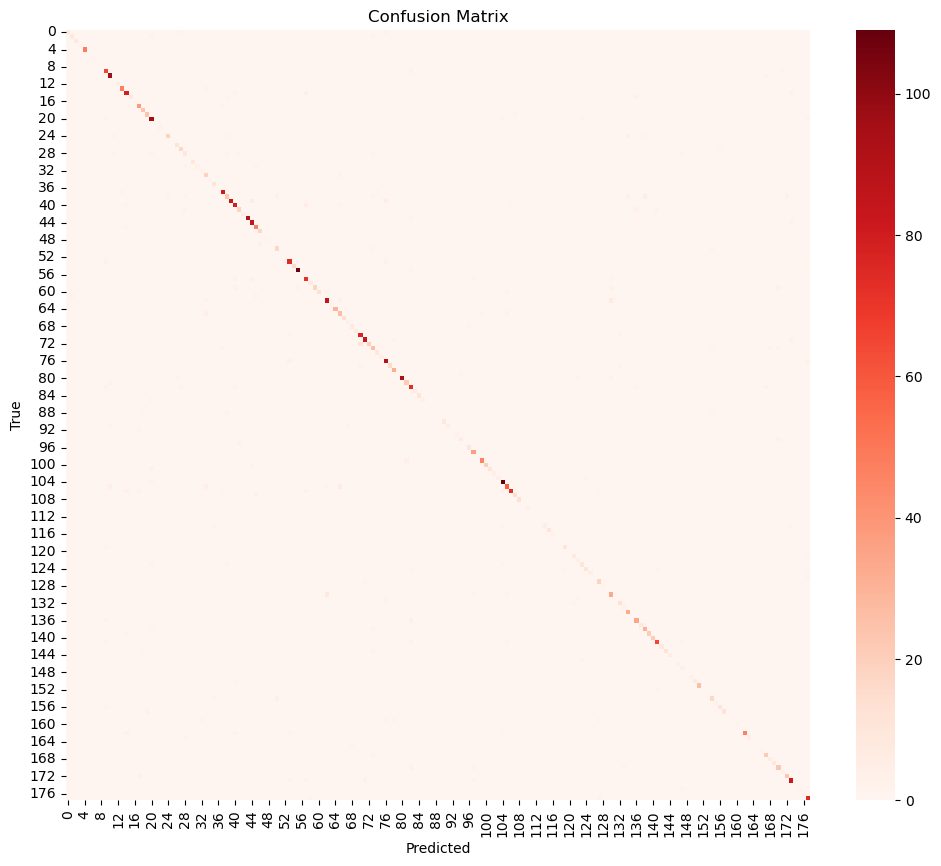

In [32]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [31]:
evaluate_model(model, val_loader, device)

100%|███████████████████████████████████████████| 77/77 [01:33<00:00,  1.21s/it]

Accuracy: 0.7120
Precision: 0.7126
Recall: 0.7120
F1 Score: 0.7037



/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nothing/anaconda3/envs/uni/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
